In [ ]:
# default_exp stft

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
#export
from rtma.imports import *
from rtma.signal import *

# STFT

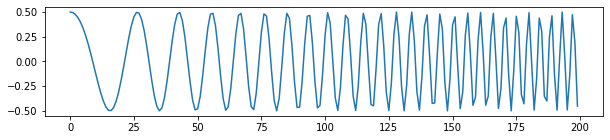

In [4]:
sr = 100
amp = 0.5
n_fft = 128
freq = [sr / n_fft * f for f in [3, 17]]
num_samples = 200

x = gen_sinusoid(amp, freq=freq, sample_rate=sr, num_samples=num_samples)
plot(x)

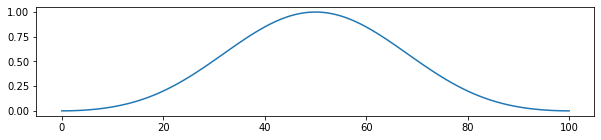

In [5]:
h = 33
m = 101
w = np.blackman(m)
plot(w)

In [6]:

# buf = np.zeros(n_fft)
# buf[:m] = wx
# buf = np.roll(buf, -(m//2))
# X = np.fft.rfft(buf, n=n_fft)
# mx = abs(X)
# px = np.unwrap(np.angle(X))
# plot(mx)

### librosa

In [7]:
import librosa

In [8]:
from librosa.filters import get_window
from numpy.lib.stride_tricks import as_strided


In [9]:
def frame(x, frame_length=2048, hop_length=512, axis=-1):
    n_frames = 1 + (x.shape[axis] - frame_length) // hop_length
    strides = np.asarray(x.strides)

    new_stride = np.prod(strides[strides > 0] // x.itemsize) * x.itemsize

    if axis == -1:

        shape = list(x.shape)[:-1] + [frame_length, n_frames]
        strides = list(strides) + [hop_length * new_stride]

    elif axis == 0:
        shape = [n_frames, frame_length] + list(x.shape)[1:]
        strides = [hop_length * new_stride] + list(strides)
    return as_strided(x, shape=shape, strides=strides)

In [10]:
def pad_center(data, size, axis=-1, **kwargs):
    kwargs.setdefault('mode', 'constant')

    n = data.shape[axis]

    lpad = int((size - n) // 2)

    lengths = [(0, 0)] * data.ndim
    lengths[axis] = (lpad, int(size - n - lpad))

    if lpad < 0:
        raise ParameterError(('Target size ({:d}) must be '
                              'at least input size ({:d})').format(size, n))

    return np.pad(data, lengths, **kwargs)

In [11]:
def librosa_stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann',
         center=True, dtype=np.complex64, pad_mode='reflect'):
    
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
#     util.valid_audio(y)

    # Pad the time series so that frames are centered
    if center:
        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    # Window the time series.
    y_frames = frame(y, frame_length=n_fft, hop_length=hop_length)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty((int(1 + n_fft // 2), y_frames.shape[1]),
                           dtype=dtype,
                           order='F')

    fft = np.fft

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = int(2**8 * 2**10 / (stft_matrix.shape[0] *
                                 stft_matrix.itemsize))

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        stft_matrix[:, bl_s:bl_t] = fft.rfft(fft_window *
                                             y_frames[:, bl_s:bl_t],
                                             axis=0)
    return stft_matrix

In [12]:
X = librosa.stft(x,
                 n_fft=n_fft, 
                 hop_length=h,
                 win_length=m,
                 window='hann',
                 center=True,
                 pad_mode='constant')
mX = abs(X) #/ np.hanning(m).sum()
# mX = librosa.amplitude_to_db(mX)
#mX[mX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
#mX = 20.0 * np.log10(mX)
mX.shape, mX.sum(), mX.min(), mX.max(), mX.mean()

((65, 7), 406.0124, 3.293504e-05, 7.754284, 0.89233494)

In [13]:
# X = librosa_stft(x,
#                  n_fft=n_fft, 
#                  hop_length=h,
#                  win_length=m,
#                  window='hanning',
#                  center=True,
#                  pad_mode='constant')
# mX = abs(X)
# # mX = librosa.amplitude_to_db(mX)
# #mX[mX<np.finfo(float).eps] = np.finfo(float)def gen_frames(x, m, h):
#     x = np.pad(x, (m2, m1), 'constant')
#     i = 0
#     while i < x.size:
#         frame = x[i:i+m]
#         frame = np.pad(frame, (0, m-frame.size), 'constant')
#         yield frame
#         i += h.eps    # if zeros add epsilon to handle log
# #mX = 20.0 * np.log10(mX)
# mX.shape, mX.sum(), mX.min(), mX.max()

### sms-tools

In [14]:
from scipy.fftpack import fft, ifft

In [15]:
tol = 1e-14                                                 # threshold used to compute phase

In [16]:
def isPower2(num):
    """
    Check if num is power of two
    """
    return ((num & (num - 1)) == 0) and num > 0

In [17]:
def dftAnal(x, w, N):
    """
    Analysis of a signal using the discrete Fourier transform
    x: input signal, w: analysis window, N: FFT size 
    returns mX, pX: magnitude and phase spectrum
    """

    if not(isPower2(N)):                                 # raise error if N not a power of two
        raise ValueError("FFT size (N) is not a power of 2")

    if (w.size > N):                                        # raise error if window size bigger than fft size
        raise ValueError("Window size (M) is bigger than FFT size")

    hN = (N//2)+1                                           # size of positive spectrum, it includes sample 0
    hM1 = (w.size+1)//2                                     # half analysis window size by rounding
    hM2 = w.size//2                                         # half analysis window size by floor
    fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
    w = w / sum(w)                                          # normalize analysis window
    xw = x*w                                                # window the input sound
    fftbuffer[:hM1] = xw[hM2:]                              # zero-phase window in fftbuffer
    fftbuffer[-hM2:] = xw[:hM2]        
    X = fft(fftbuffer)                                      # compute FFT
    absX = abs(X[:hN])                                      # compute ansolute value of positive side
    mX = absX
    #absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
    #mX = 20 * np.log10(absX)                                # magnitude spectrum of positive frequencies in dB
    #X[:hN].real[np.abs(X[:hN].real) < tol] = 0.0            # for phase calculation set to 0 the small values
    #X[:hN].imag[np.abs(X[:hN].imag) < tol] = 0.0            # for phase calculation set to 0 the small values         
    pX = np.unwrap(np.angle(X[:hN]))                        # unwrapped phase spectrum of positive frequencies
    return mX, pX

In [18]:
def stftAnal(x, w, N, H) :
    """
    Analysis of a sound using the short-time Fourier transform
    x: input array sound, w: analysis window, N: FFT size, H: hop size
    returns xmX, xpX: magnitude and phase spectra
    """
    if (H <= 0):                                   # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")
    
    M = w.size                                      # size of analysis window
    hM1 = (M+1)//2                                  # half analysis window size by rounding
    hM2 = M//2                                      # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                  # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM2))                  # add zeros at the end to analyze last sample
    pin = hM1                                       # initialize sound pointer in middle of analysis window       
    pend = x.size-hM1                               # last sample to start a frame
    w = w / sum(w)                                  # normalize analysis window
    xmX = []                                       # Initialise empty list for mX
    xpX = []                                       # Initialise empty list for pX
    while pin<=pend:                                # while sound pointer is smaller than last sample      
        x1 = x[pin-hM1:pin+hM2]                     # select one frame of input sound
        mX, pX = dftAnal(x1, w, N)              # compute dft
        xmX.append(np.array(mX))                    # Append output to list
        xpX.append(np.array(pX))
        pin += H                                    # advance sound pointer
    xmX = np.array(xmX)                             # Convert to numpy array
    xpX = np.array(xpX)
    return xmX, xpX

In [19]:
# w = np.blackman(m)
# w = np.ones(m)
w = np.hanning(m)
xmX, xpX = stftAnal(x, w, n_fft, h)
xmX.shape, xmX.sum(), xmX.min(), xmX.max(), xmX.mean()

((7, 65),
 8.062600880499435,
 5.3206265873064e-07,
 0.1536433338962786,
 0.01772000193516359)

In [20]:
abs(xmX - mX.T).max()

7.6006405711330185

In [21]:
xmX.max()

0.1536433338962786

In [22]:
xmX[0][:10], mX.T[0][:10]

(array([0.02103159, 0.02865726, 0.0469135 , 0.07157498, 0.1004608 ,
        0.12363387, 0.12418984, 0.09373669, 0.04312395, 0.00579466]),
 array([1.0620152 , 1.4374077 , 2.3400347 , 3.5604448 , 4.9878516 ,
        6.130165  , 6.1522985 , 4.640628  , 2.1338854 , 0.30593044],
       dtype=float32))

In [23]:
def gen_frames(x, m, h):
    x = np.pad(x, (m2, m1), 'constant')
    i = 0
    while i < x.size:
        frame = x[i:i+m]
        frame = np.pad(frame, (0, m-frame.size), 'constant')
        yield frame
        i += h

In [32]:
import math

In [33]:
def dftSynth(mX, pX, M):
    """
    Synthesis of a signal using the discrete Fourier transform
    mX: magnitude spectrum, pX: phase spectrum, M: window size
    returns y: output signal
    """

    hN = mX.size                                            # size of positive spectrum, it includes sample 0
    N = (hN-1)*2                                            # FFT size
    if not(isPower2(N)):                                 # raise error if N not a power of two, thus mX is wrong
        raise ValueError("size of mX is not (N/2)+1")

    hM1 = int(math.floor((M+1)/2))                          # half analysis window size by rounding
    hM2 = int(math.floor(M/2))                              # half analysis window size by floor
    fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
    y = np.zeros(M)                                         # initialize output array
    Y = np.zeros(N, dtype = complex)                        # clean output spectrum
    Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                    # generate positive frequencies
    Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(-1j*pX[-2:0:-1]) # generate negative frequencies
    fftbuffer = np.real(ifft(Y))                            # compute inverse FFT
    y[:hM2] = fftbuffer[-hM2:]                              # undo zero-phase window
    y[hM2:] = fftbuffer[:hM1]
    return y

In [41]:
def stft(x, w, N, H):
    """
    Analysis/synthesis of a sound using the short-time Fourier transform
    x: input sound, w: analysis window, N: FFT size, H: hop size
    returns y: output sound
    """
    
    if (H <= 0):                                   # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")
    
    M = w.size                                     # size of analysis window
    hM1 = (M+1)//2                                 # half analysis window size by rounding
    hM2 = M//2                                     # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                 # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                 # add zeros at the end to analyze last sample
    pin = hM1                                      # initialize sound pointer in middle of analysis window       
    pend = x.size-hM1                              # last sample to start a frame
    w = w / sum(w)                                 # normalize analysis window
    y = np.zeros(x.size)                           # initialize output array
    while pin<=pend:                               # while sound pointer is smaller than last sample      
    #-----analysis-----  
        x1 = x[pin-hM1:pin+hM2]                    # select one frame of input sound
#         mX, pX = dftAnal(x1, w, N)             # compute dft
#     #-----synthesis-----
#         y1 = dftSynth(mX, pX, M)               # compute idft
        y[pin-hM1:pin+hM2] += H*x1                 # overlap-add to generate output sound
        pin += H                                   # advance sound pointer
    y = np.delete(y, range(hM2))                   # delete half of first window which was added in stftAnal
    y = np.delete(y, range(y.size-hM1, y.size))    # delete half of the last window which as added in stftAnal
    return y

In [47]:
n = 100
h = 12
m = 25

x = np.ones(n)
w = get_window('hanning', m)

In [48]:
y = stft(x, w, 32, h)

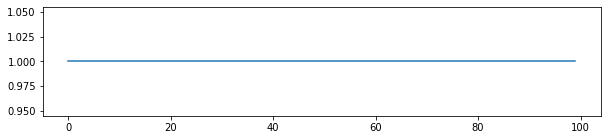

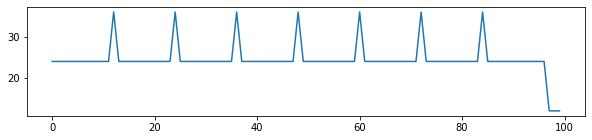

In [50]:
plot(x)
plot(y)

In [51]:
from scipy import signal

In [58]:
f,t,z = signal.stft(x, window='hamming', nperseg=m, noverlap=m-h)


In [65]:
_,y = signal.istft(z, window='hamming', nperseg=m, noverlap=m-h)

In [66]:
y.shape, x.shape

((109,), (100,))

In [68]:
y[:x.size]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [80]:
D = librosa.stft(x, n_fft=32, hop_length=h, win_length=m, window='hamming', pad_mode='constant')

In [85]:
y = librosa.istft(D, hop_length=h, win_length=m, window='hamming')

In [89]:
y.min(), y.max()

(0.99999994, 1.0000001)

In [78]:
x.shape

(100,)